# TP 3: Hasting-Metropolis (and Gibbs) samplers

### Student : Simon Queric

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

### 1.A – A population model for longitudinal data

#### Question 1

The complete log-likelihood writes : 


$p(y, z, \theta) = p(y | z, \theta)p(z_{ind} | \theta_{ind})p(\theta_{ind})p(z_{pop} | \theta_{pop})p(\theta_{pop}) $

Hence, the log-likelihood writes, up to an additive constant : 

\begin{equation*}
    \begin{aligned}
        \log{p(y, z, \theta)} &=  \log{p((y_{i,j})_{i, j} | (z_i)_i, z_{pop}, \theta)} + \log{p((z_{i})_i, z_{pop} | \theta} + \log{p(\theta)}  \\
        &=\sum_{i=1}^N\sum_{j=1}^{K} \Bigg( -\log{\sigma} - \frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2} \Bigg) \\
        &- \sum_{i=1}^N{\Bigg(\log{\alpha_i} - \log{\sigma_{\xi}} - \frac{(\log{\alpha_i})^2}{2\sigma_{\xi}} - \log{\sigma_{\tau}} - \frac{\tau_i^2}{2\sigma_{\tau}^2} \Bigg)} -\log{\sigma_{t_0}^2} - \frac{(t_0 - \overline{t_0})^2}{2\sigma_{t_0}^2} -\log{\sigma_{v_0}^2} - \frac{(v_0 - \overline{v_0})^2}{2\sigma_{v_0}^2} \\
        & -(m_{\xi} + 2)\log{\sigma_{\xi}}  - \frac{v_{\xi}^2}{2\sigma_{\xi}} - (m_{\tau} +2)\log{\sigma_{\tau}} -  \frac{v_{\tau}^2}{2\sigma_{\tau}^2} - (m+2)\log{\sigma} -\frac{v^2}{2\sigma^2} \\
        &- \log{s_{t_0}} - \frac{(\overline{t_0} - \overline{\overline{t_0}})^2}{2s_{t_0}^2} -\log{s_{v_0}} - \frac{(\overline{v_0} - \overline{\overline{v_0}})^2}{2s_{v_0}^2} \\
        & = \sum_{i=1}^N\sum_{j=1}^{K}-\frac{(y_{i, j} - d_i(t_{i,j}))^2}{2\sigma^2} - \sum_{i=1}^N{\Bigg(\log{\alpha_i} - \frac{(\log{\alpha_i})^2}{2\sigma_{\xi}^2} - \frac{\tau_i^2}{2\sigma_{\tau}^2}\Bigg)}\\
        & - (NK + (m+2))\log{\sigma} - (N + (m_{\tau}+2))\log{\sigma_{\tau}} - (N + (m_{\xi}+2))\log{\sigma_{\xi}} \\
        &-\log{\sigma_{t_0}^2} - \frac{(t_0 - \overline{t_0})^2}{2\sigma_{t_0}^2} -\log{\sigma_{v_0}^2} - \frac{(v_0 - \overline{v_0})^2}{2\sigma_{v_0}^2} - \frac{v_{\xi}^2}{2\sigma_{\xi}} - \frac{v_{\tau}^2}{2\sigma_{\tau}^2} -\frac{v^2}{2\sigma^2}  \\
        &- \log{s_{t_0}} - \frac{(\overline{t_0} - \overline{\overline{t_0}})^2}{2s_{t_0}^2} -\log{s_{v_0}} - \frac{(\overline{v_0} - \overline{\overline{v_0}})^2}{2s_{v_0}^2}
    \end{aligned}
\end{equation*}


We can write the log-likelihood as $-\varphi(\theta) + \langle S(y, z), \psi(\theta) \rangle$ 

where 

\begin{equation*}
    \varphi(\theta) = \frac{\overline{t_0}^2}{2\sigma_{t_0}^2} + \frac{\overline{t_0}^2}{2s_{t_0}^2} - \frac{\overline{t_0}\overline{\overline{t_0}}}{s_{t_0}^2}
    + (N + m_{\xi} + 2)\log{\sigma_{\xi}}
    + \frac{\overline{v_0}^2}{2\sigma_{v_0}^2} + \frac{\overline{v_0}^2}{2s_{v_0}^2} - \frac{\overline{v_0}\overline{\overline{v_0}}}{s_{v_0}^2} 
    + (N + m_{\tau} + 2)\log{\sigma_{\tau}}
    + (KN + m + 2)\log{\sigma} 
    - \frac{v_{\xi}^2}{2\sigma_{\xi}^2}
    - \frac{v_{\tau}^2}{2\sigma_{\tau}^2}
    - \frac{v_{\sigma}^2}{2\sigma^2}
\end{equation*}

\begin{equation*}
    S(y, z) = \left( \frac{1}{KN}\sum_{i, j}{\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2}}, \frac{1}{N}\sum_{i=1}^N{\log{\alpha_i}^2}, \frac{1}{N}\sum_{i=1}^N{\tau_i^2}, t_0, v_0 \right)^T 
    \text{ and  }
    \psi(\theta) = \left( -\frac{KN}{2\sigma^2}, -\frac{N}{2\sigma_{\xi}^2}, -\frac{N}{2\sigma_{\tau}^2}, \frac{\overline{t_0}}{\sigma_{t_0}^2}, \frac{\overline{v_0}}{\sigma_{v_0}^2}  \right)^T
\end{equation*}



#### Question 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import invgamma
from numba import jit

In [2]:
def get_param(N=100, k=20) :
    """Init parameters of the model"""
    sigma_t0 = 0.1
    sigma_v0 = 0.1
    s_t0 = 0.1
    s_v0 = 0.1
    t0__ = 1
    v0__ = 1
    m = np.random.uniform(5, 10)
    m_xi, m_tau = m, m
    v = np.random.uniform(1, 5)
    v_xi, v_tau = v, v

    t0_ = np.random.normal(t0__, s_t0)
    v0_ = np.random.normal(v0__, s_v0)
    sigma_xi2 = invgamma.rvs(a = m_xi/2, scale=v_xi**2/2)
    sigma_tau2 = invgamma.rvs(a = m_tau/2, scale=v_tau**2/2)
    sigma2 = invgamma.rvs(a=m/2, scale=v/2)

    t0 = np.random.normal(t0_, sigma_t0)
    v0 = np.random.normal(v0_, sigma_v0)    

    return (sigma_t0, sigma_v0, s_t0, s_v0, t0__, v0__, m_xi, 
            m_tau, m, v, v_xi, v_tau, t0_, v0__, sigma_xi2, sigma_tau2, sigma2, t0, v0)

In [3]:
@jit(nopython=True)
def generate_data(v0, t0, sigma2, sigma_xi2, sigma_tau2, k, N) :
    """Generate synthetic observations of the model"""
    d = lambda t : v0*(t - t0)
    eps = np.random.normal(0, np.sqrt(sigma2), size=(N, k))
    alpha = np.exp(np.random.normal(0, np.sqrt(sigma_xi2), size=(N)))
    tau = np.random.normal(0, np.sqrt(sigma_tau2), size=(N))
    t = np.zeros((N, k))
    for i in range(N) :
        t[i] = np.linspace(0, k, k)

    t = (alpha*((t - t0).T - tau)).T + t0
    y = d(t) + eps
    return y, alpha, tau

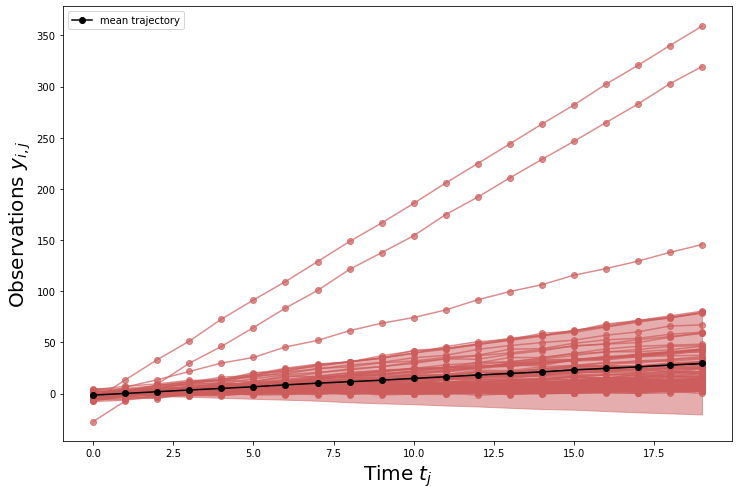

In [4]:
N = 100
k = 20
(sigma_t0, sigma_v0, s_t0, s_v0, t0__, v0__, m_xi, m_tau, m, v, v_xi, v_tau, t0_,
 v0_, sigma_xi2, sigma_tau2, sigma2, t0, v0) = get_param(N, k)


y, alpha, tau = generate_data(v0, t0, sigma2, sigma_xi2, sigma_tau2, k, N)

z_true = np.zeros(2*N+2)
z_true[0] = t0
z_true[1] = v0
z_true[2:N+2] = np.log(alpha)
z_true[N+2:] = tau

theta_true = np.array([np.sqrt(sigma2), np.sqrt(sigma_xi2), np.sqrt(sigma_tau2), t0_, v0_ ])

fig = plt.figure(figsize=(12, 8))
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
plt.plot(y_mean, "k", marker='o')
for n in range(N) :
    plt.plot(y[n,:], alpha=0.7, color="indianred", ls="-", marker='o')
plt.plot(y_mean, "k", marker='o')
plt.fill_between(list(range(k)), y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")
plt.legend(["mean trajectory"])
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$", fontsize=20)
plt.show()

In [5]:
print(theta_true)

[0.99295067 1.12461377 1.44787238 1.07208532 1.        ]


### 1.B – HM-SAEM – Hasting-Metropolis sampler

#### Question 3-4

We want to sample the posterior distribution of $$ z = (t_0, v_0, (\xi_i)_{1\leqslant i \leqslant N}, (\tau_i)_{1\leqslant i \leqslant N}) \in \mathbb{R}^{2N+2}$$
given $(y, \theta)$ : 

$$ p(z | y, \theta) \propto p(y, \theta | z)p(z) $$

$p(y, \theta | z)p(z) =p(y | \theta, z)p(\theta|z)p(z) 
= p(y|\theta, z)p(z|\theta)p(\theta) \propto p(y|\theta, z)p(z|\theta)$

We have, up to an additive constant : 

$$\log{p(y_{i,j} | \theta, z)} = -\log{\sigma} - \frac{(y_{i,j}-d_i(t_{i,j}))^2}{2\sigma^2} $$

$$ \log{p(z_i|\theta_{ind})} = -\log{\sigma_{\xi}} - \frac{\xi_i^2}{2\sigma_{\xi}^2} - \log{\sigma_{\tau}} - \frac{\tau_i^2}{2\sigma_{\tau}^2} $$

and 

$$ \log{p(z_{pop} | \theta_{pop})} = - \log{\sigma_{t_0}^2} - \frac{(t_0 - \overline{t_0})^2}{2\sigma_{t_0}^2} - \log{\sigma_{v_0}^2} - \frac{(v_0 - \overline{v_0})^2}{2\sigma_{v_0}^2}  $$

We can get rid of the constant so that at the end of the day we get : 

$$\log{p(z | y, \theta)} = \sum_{i=1}^N\sum_{j=1}^K{- \frac{(y_{i,j}-d_i(t_{i,j}))^2}{2\sigma^2}} + \sum_{i=1}^N{\left(-\frac{\xi_i^2}{2\sigma_{\xi}^2} - \frac{\tau_i^2}{2\sigma_{\tau}^2}\right)} - \frac{(t_0-\overline{t_0})^2}{2\sigma_{t_0}^2} - \frac{(v_0-\overline{v_0})^2}{2\sigma_{v_0}^2} $$

where $$ d_i(t_{i,j}) = d(v_0\alpha_i(t_{i,j} - t_0 - \tau_i) - t_0) $$

In [6]:
@jit(nopython=True)
def sym_metropolis_hasting(z0, log_pi, param, sigma_prop=1e-6, n_iter=100) :
    """
    Implement a symmetric random walk metropolis hasting algorithm
    with a multivariate gaussian distribution as proposal density. 

    Parameters
    ----------
    z0 : (d, ) array
    log_pi : logarithm of the target density
    sigma_prop : non-negative float, standard deviation of the proposal
    n_iter : int, number of iterations

    Returns 
    -------

    sample : (n_iter, d) array of the generated samples
    acceptance_probability : list of size n_iter
    log_prob : list of size n_iter
    """
    z = np.copy(z0)
    d = int(z.shape[0])
    acceptance_probability = []
    log_prob = []
    sample = np.zeros((n_iter, d))
    for k in range(n_iter) :
        y = np.zeros(d) #np.random.multivariate_normal(mean=z, cov=sigma_prop*np.eye(d)) 
        for i in range(d) :
            y[i] = np.random.normal(loc=z[i], scale=sigma_prop)
        a = np.exp(min(0, log_pi(y, param=param)-log_pi(z, param=param)))
        u = np.random.uniform(0, 1)
        if u<=a : 
            z = y  
        log_prob.append(log_pi(z, param=param))
        acceptance_probability.append(a)
        sample[k] = z
    return sample, acceptance_probability, log_prob

In [7]:
@jit(nopython=True)
def log_pi(z, param) :
   N = int(len(z)/2 - 1)
   theta = np.copy(param)
   sigma2 = theta[0]**2
   sigma_xi2 = theta[1]**2
   sigma_tau2 = theta[2]**2 
   t0_, v0_ = theta[3], theta[4]
   t0 = z[0]
   v0 = z[1]
   xi = z[2:N+2]
   tau = z[N+2:]
   d = lambda t : v0*(t - t0)
   t = np.zeros((N, k))
   for i in range(N) :
      t[i] = np.linspace(0, k, k)
   t = (np.exp(xi)*((t - t0).T - tau)).T + t0
   t = d(t)
   log_pdf = -np.sum((y-t)**2)/(2*sigma2)
   log_pdf += -np.sum(xi**2)/(2*sigma_xi2) - np.sum(tau**2)/(2*sigma_tau2) 
   log_pdf += -(t0 - t0_)**2/(2*sigma_t0**2) - (v0 - v0_)**2/(2*sigma_v0**2)

   return log_pdf

In [8]:
z0 = np.zeros(2*N+2)
z0[0] = t0
z0[1] = v0
z0[2:N+2] = np.log(alpha)
z0[N+2:] = tau
log_pi(z0, param=theta_true)

-1147.7403769096127

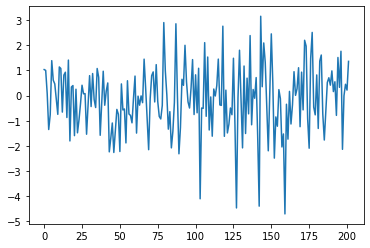

In [9]:
plt.plot(z0)

In [10]:
z_true = np.zeros(2*N+2)
z_true[0] = t0
z_true[1] = v0
z_true[2:N+2] = np.log(alpha)
z_true[N+2:] = tau

sample, acceptance_rate, log_prob = sym_metropolis_hasting(z_true, log_pi,  param=theta_true, sigma_prop=1e-7, n_iter=1000)

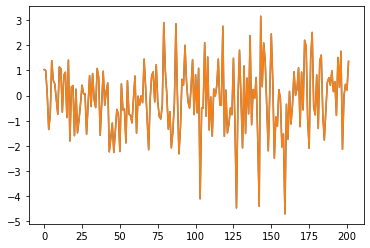

In [11]:
plt.plot(z_true)
plt.plot(sample[-1])


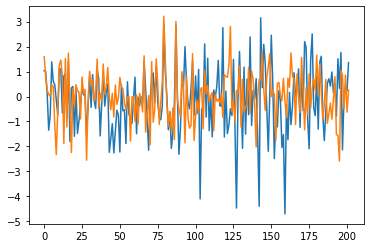

In [12]:
z0 = np.zeros(2*N+2)
z0[0]=1
z0[1] = 1
sample, acceptance_rate, log_prob = sym_metropolis_hasting(z0, log_pi, param=theta_true, sigma_prop=1e-1, n_iter=2000)
plt.plot(z_true)
plt.plot(sample[-1])
#plt.scatter(z_true, sample[-1])
#plt.plot(np.linspace(np.min(z_true), np.max(z_true)), np.linspace(np.min(z_true), np.max(z_true)), c="indianred", lw=2)
plt.show()

In [13]:
log_prob[-1]

-136745.4423976795

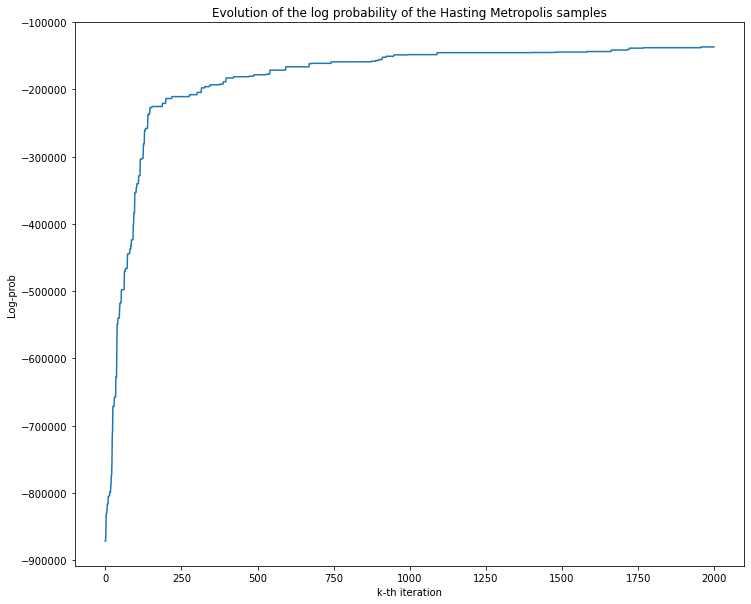

In [14]:
fig = plt.figure(figsize=(12, 10))
plt.plot(log_prob)
plt.title("Evolution of the log probability of the Hasting Metropolis samples")
plt.xlabel("k-th iteration")
plt.ylabel("Log-prob")
plt.show()

In [15]:
z0 = np.zeros(2*N+2)
z0[0], z0[1] = 1, 1

sample, acceptance_rate, log_prob = sym_metropolis_hasting(z0, log_pi, param=theta_true, sigma_prop=1e-1/2, n_iter=100)

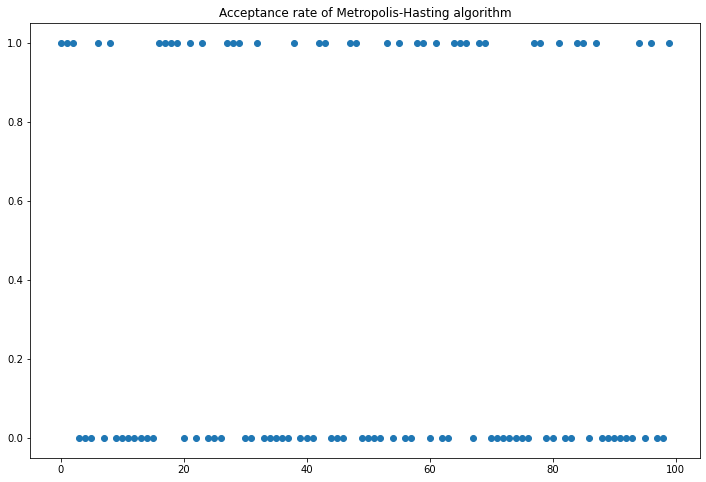

In [16]:
fig = plt.figure(figsize=(12, 8))
acceptance_rate = np.array(acceptance_rate)
plt.plot((acceptance_rate), 'o')
plt.title("Acceptance rate of Metropolis-Hasting algorithm")
plt.show()

In [17]:
print(acceptance_rate.mean(), acceptance_rate.std())

0.39 0.4877499359302879


#### Question 4

At step $k$, we want to compute  

$$ \theta^{(k)} = \underset{\theta \in \Theta}{\text{argmax}} \left\{ -\varphi(\theta) + \langle S^{(k)}, \psi(\theta) \rangle \right\}$$

By taking the gradient equal to zero, we get the following updates : 

\begin{equation*}
    \begin{aligned}
        \sigma^{(k)} &= \sqrt{\frac{KNS_1^{(k)} + v^2}{KN+m + 2}} \\
        \sigma_{\xi}^{(k)} &= \sqrt{\frac{NS_2^{(k)} +v_{\xi}^2}{N+m_{\xi} + 2}} \\
        \sigma_{\tau}^{(k)} &= \sqrt{\frac{NS_3^{(k)} + v_{\tau}^2}{N+m_{\tau} + 2}} \\
        \overline{t_0}^{(k)} &= \left(\frac{\overline{\overline{t_0}}}{s_{t_0}^2} + \frac{S^{(k)}_4}{\sigma_{t_0}^2} \right) / \left( {\frac{1}{s_{t_0}^2} + \frac{1}{\sigma_{t_0}^2}} \right) \\
        \overline{v_0}^{(k)} &= \left(\frac{\overline{\overline{v_0}}}{s_{v_0}^2} + \frac{S^{(k)}_5}{\sigma_{v_0}^2} \right) / \left( {\frac{1}{s_{v_0}^2} + \frac{1}{\sigma_{v_0}^2}} \right)\\

    \end{aligned} 
\end{equation*}

In [18]:
@jit(nopython=True)
def S(y, z) :
    """
    Compute the sufficient statistics of the longitudinal model
        
    Parameters
    ----------
    
    y : (N, K) array of observations 
    z : (5, ) array of latent variables
    
    Returns
    -------

    s : (5, ) array of the sufficient statistics
    """
    N, K = y.shape
    t0 = z[0]
    v0 = z[1]
    alpha = np.exp(z[2:N+2])
    tau = z[N+2:]

    s = np.zeros(5)
    d = lambda t : v0*(t - t0)
    t = np.zeros((N, k))
    for i in range(N) :
      t[i] = np.linspace(0, k, k)    
    t = (alpha*((t - t0).T - tau)).T + t0

    s[0] = np.mean((y-d(t))**2)
    s[1] = np.mean(np.log(alpha)**2)
    s[2] = np.mean(tau**2)
    s[3] = t0
    s[4] = v0

    return s

In [19]:
z_true = np.zeros(2*N+2)
z_true[0] = t0
z_true[1] = v0
z_true[2:N+2] = np.log(alpha)
z_true[N+2:] = tau

In [20]:
theta_true = np.array([np.sqrt(sigma2), np.sqrt(sigma_xi2), np.sqrt(sigma_tau2), t0_, v0_ ])

In [21]:
def hm_saem(z0, theta0, y, nb_iter = 50, hm_iter=100, sigma_prop=1e-6, n_burn_in=10, alpha=3/2) :
    """SAEM implementation for a longitudinal model"""
    N, K = y.shape
    zk = np.copy(z0) 
    thetak = np.copy(theta0) 
    Sk = 0
    parameters = np.zeros((nb_iter, thetak.shape[0]))
    for k in range(1, nb_iter+1) :
        if k<= n_burn_in : 
            eps = 1
        else : 
            eps = (k-n_burn_in)**(-alpha)
        
        sample, _, _ = sym_metropolis_hasting(zk, log_pi, param=thetak, sigma_prop=sigma_prop, n_iter=hm_iter)
        zk = sample[-1]
        Sk = Sk + eps*(S(y, zk) - Sk)
        thetak[0] = np.sqrt((K*N*Sk[0] + v**2)/(K*N+m+2))
        thetak[1] = np.sqrt((N*Sk[1] + v_xi**2)/(N+m_xi+2))
        thetak[2] = np.sqrt((N*Sk[2] + v_tau**2)/(N+m_tau+2))
        thetak[3] = (t0__/(s_t0**2) + Sk[3]/(sigma_t0**2))/(1/(s_t0**2) + 1/(sigma_t0**2))
        thetak[4] = (v0__/(s_v0**2) + Sk[4]/(sigma_v0**2))/(1/(s_v0**2) + 1/(sigma_v0**2))

        parameters[k-1] = thetak

    return thetak, zk, parameters

In [52]:
theta, z, param = hm_saem(z_true, theta_true, y, nb_iter = 20, hm_iter=100, sigma_prop=1e-6, n_burn_in=10, alpha=3/2)

In [53]:
theta_true

array([0.99295067, 1.12461377, 1.44787238, 1.07208532, 1.        ])

In [54]:
theta

array([1.01584812, 1.10214535, 1.51394444, 1.01677327, 1.00095786])

In [55]:
theta, z, param = hm_saem(np.zeros(2*N+2), np.ones(5), y, nb_iter=1000, hm_iter=100, sigma_prop=1e-2/2, n_burn_in=500, alpha=(1+1e-2)/2)

In [56]:
theta

array([1.35880418, 1.01728153, 0.52660652, 0.94497058, 0.91953657])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


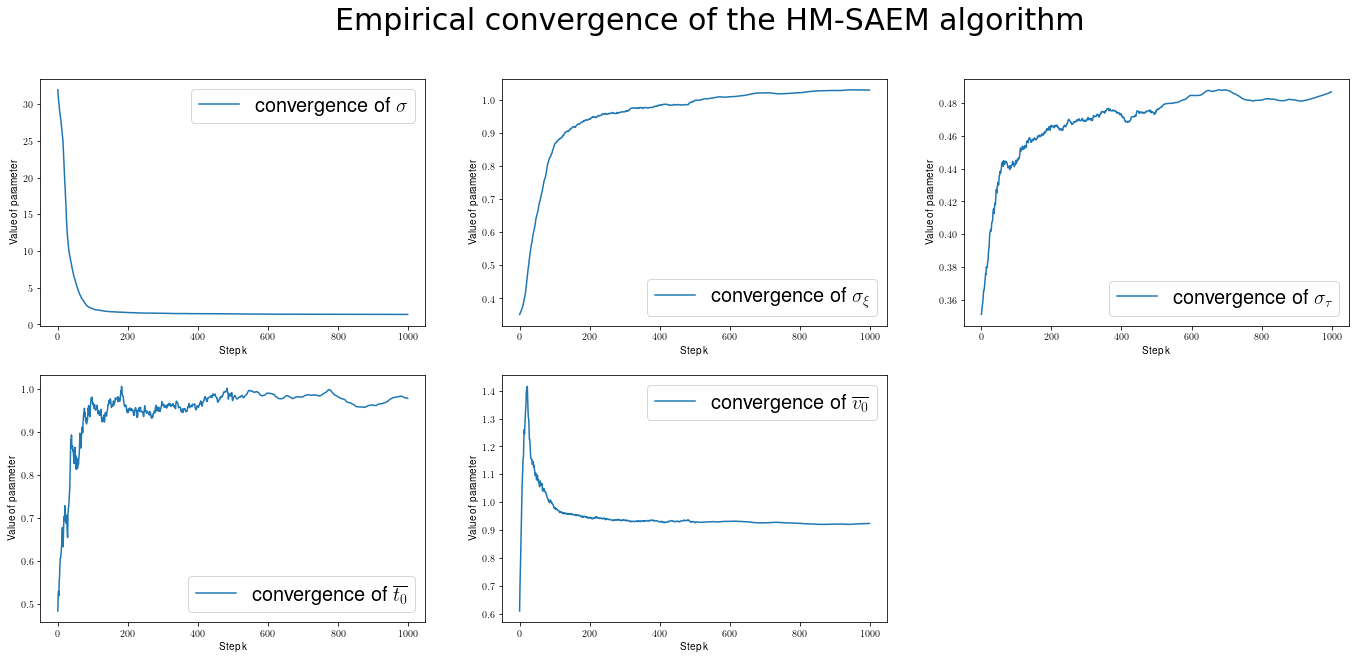

In [27]:
name_param = ["$\sigma$ ", r"$\sigma_{\xi}$", r"$\sigma_{\tau}$", r"$\overline{t_0}$", r"$\overline{v_0}$"]

fig = plt.figure(figsize=(40, 10))
t = 0.7
mid =  t*fig.subplotpars.left + (1-t)*fig.subplotpars.right
fig.suptitle("Empirical convergence of the HM-SAEM algorithm", fontsize=30, x=mid)

gs = GridSpec(2, 5, width_ratios=[2, 2, 2, 2, 2])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

for i in range(len(theta)) :
    q, r = i//3, i%3 
    axs[i].plot(param[:,i])
    axs[i].set_xlabel("Step k")
    axs[i].set_ylabel("Value of parameter")
    axs[i].legend(["convergence of " + name_param[i]], fontsize=20)
#plt.savefig('test.pdf') 
plt.show()

### 1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sampler

#### Question 5

Firts, we can notice that 

\begin{equation*}
    \begin{aligned}
        p(z_i|z_{pop}, y, \theta) &= p(y_i|z_i, z_{pop}, \theta)p(\theta, z_{pop}|z_i)p(z_i) \\
        &= p(y_i|z_i, z_{pop}, \theta)p(z_{pop}|z_i, \theta)p(\theta|z_i)p(z_i) \\
        &= p(y_i|z_i, z_{pop}, \theta)p(z_{pop}|\theta)p(z_i|\theta)p(\theta) \\
        &\propto  p(y_i|z_i, z_{pop}, \theta)p(z_i|\theta)
    \end{aligned}
\end{equation*}

We work in the log domain so that we get, up to an additive constant, 

\begin{equation*}
    \begin{aligned}
     \log{p(z_i|z_{pop}, y, \theta)} &= \sum_{j=1}^K{\log\mathcal{N}(d_i(t_{i,j}), \sigma^2)(y_{i,j})} + \log\mathcal{N}(0, \sigma_{\xi}^2)(\xi_i) + \log\mathcal{N}(0, \sigma_{\tau}^2)(\tau_i) \\
     &= \sum_{j=1}^K{-\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2}} - \frac{\xi_i^2}{2\sigma_{\xi}^2} - \frac{\tau_i^2}{2\sigma_{\tau}^2}
     \end{aligned}
\end{equation*}

The Gibbs sampler writes 

\begin{equation*}
\begin{aligned}
    & \text{Given } z_i^{(k)} = (\xi_i^{(k)}, \tau_i^{(k)}) \\
    & 1. \text{ Sample } \xi_i^{(k+1)} \sim p(\cdot |z_{pop}, y, \theta, \tau_i^{(k)}) \\
    & 2. \text{ Sample } \tau_i^{(k+1)} \sim p(\cdot |z_{pop}, y, \theta, \xi_i^{(k+1)}) \\
\end{aligned}
\end{equation*}

where we sample the conditional distribution thanks to the HM algorithm.

#### Question 6

Let's write down the conditional density : 

\begin{equation*}
    \begin{aligned}
        p(z_{pop} | (z_i)_i, y, \theta) &= p((z_i)_i, y, \theta | z_{pop})p(z_{pop}) \\
        &= p(y|\theta, z)p(\theta, (z_i)_i | z_{pop})p(z_{pop}) \\
        &= p(y | \theta, z)p((z_i)_i | \theta, z_{pop})p(\theta|z_{pop})p(z_{pop}) \\
        &\propto p(y|\theta, z)p((z_i)_i | \theta)p(z_{pop} | \theta) \\
        &\propto p(y|\theta, z)p(z_{pop} | \theta)
    \end{aligned}
\end{equation*}

We work in the log domain so that we get, up to an additive constant, 

\begin{equation*}
    \begin{aligned}
     \log{p(z_{pop} |(z_i)_i, y, \theta)} &= \sum_{i=1}^N\sum_{j=1}^K{\log\mathcal{N}(d_i(t_{i,j}), \sigma^2)(y_{i,j})} - \frac{(t_0-\overline{t_0})^2}{2\sigma_{t_0}^2} - \frac{(v_0-\overline{v_0})^2}{2\sigma_{v_0}^2} \\
     &= \sum_{i=1}^N\sum_{j=1}^K{-\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2}} - \frac{(t_0-\overline{t_0})^2}{2\sigma_{t_0}^2} - \frac{(v_0-\overline{v_0})^2}{2\sigma_{v_0}^2}
     \end{aligned}
\end{equation*}

The Gibbs sampler writes 

\begin{equation*}
\begin{aligned}
    & \text{Given } z_{pop}^{(k)} = (t_0^{(k)}, v_0^{(k)}) \\
    & 1. \text{ Sample } t_0^{(k+1)} \sim p(\cdot |(z_i)_i, y, \theta, v_0^{(k)}) \\
    & 2. \text{ Sample } v_0^{(k+1)} \sim p(\cdot |(z_i)_i, y, \theta, t_0^{(k)}) \\
\end{aligned}
\end{equation*}

#### Question 7

In [28]:
@jit(nopython=True)
def log_pi_xi(xi_i, param) :
    z_pop, z_ind, i, y, theta = np.copy(param[0]), np.copy(param[1]), param[2], np.copy(param[3]), np.copy(param[4])
    N, K = y.shape
    t0 = z_pop[0]
    v0 = z_pop[1]
    xi = z_ind[:N]
    xi[i] = xi_i[0]
    tau = z_ind[N:]
    d = lambda t : v0*(t - t0)
    t = np.zeros((N,k))
    for j in range(N) :
      t[j] = np.linspace(0, K, K)    
    t = (np.exp(xi)*((t - t0).T - tau)).T + t0
    t = d(t)

    log_prob = np.sum(-(y[i]-t[i,:])**2)/(2*theta[0]**2) - xi[i]**2/(2*theta[1]**2)

    return log_prob

@jit(nopython=True)
def log_pi_tau(tau_i, param) :
    z_pop, z_ind, i, y, theta = np.copy(param[0]), np.copy(param[1]), param[2], np.copy(param[3]), np.copy(param[4])
    N, K = y.shape
    t0 = z_pop[0]
    v0 = z_pop[1]
    xi = z_ind[:N]
    tau = z_ind[N:]
    tau[i] = tau_i[0]
    d = lambda t : v0*(t - t0)
    t = np.zeros((N,K))
    for j in range(N) :
      t[j] = np.linspace(0, K, K)    
    t = (np.exp(xi)*((t - t0).T - tau)).T + t0
    t = d(t)

    log_prob = np.sum(-(y[i]-t[i,:])**2)/(2*theta[0]**2) - tau[i]**2/(2*theta[2]**2)

    return log_prob

@jit(nopython=True)
def log_pi_t0(t0, param) :
    z_ind, z_pop, y, theta = np.copy(param[0]), np.copy(param[1]), np.copy(param[2]), np.copy(param[3])
    N, K = y.shape
    t0_tilde = t0[0]
    v0 = z_pop[1]
    xi = z_ind[:N]
    tau = z_ind[N:]
    d = lambda t : v0*(t - t0_tilde)
    t = np.zeros((N, k))
    for i in range(N) :
      t[i] = np.linspace(0, K, K)    
    t = (np.exp(xi)*((t - t0_tilde).T - tau)).T + t0_tilde
    t = d(t)

    log_prob = np.sum(-(y-t)**2)/(2*theta[0]**2) - (t0_tilde - theta[3])**2/(2*sigma_t0**2) 

    return log_prob

@jit(nopython=True)
def log_pi_v0(v0, param) :
    z_ind, z_pop, y, theta = np.copy(param[0]), np.copy(param[1]), np.copy(param[2]), np.copy(param[3])
    
    N, K = y.shape
    v0_tilde = v0[0]
    t0 = z_pop[0]
    xi = z_ind[:N]
    tau = z_ind[N:]
      
    d = lambda t : v0_tilde*(t - t0)
    t = np.zeros((N, k))
    for i in range(N) :
      t[i] = np.linspace(0, K, K)    
    t = (np.exp(xi)*((t - t0).T - tau)).T + t0
    t = d(t)

    log_prob = - (v0_tilde - theta[4])**2/(2*sigma_v0**2) + np.sum(-(y-t)**2)/(2*theta[0]**2) 

    return log_prob

In [29]:
@jit(nopython=True)
def metropolis_hasting_within_gibbs(z0, y, theta, n_iter=100, hm_iter=100, sigma_prop=1e-3) :
    """Random scan Metropolis-Hasting"""
    
    z_pop = np.copy(z0[:2])
    t0 = z_pop[0]
    v0 = z_pop[1]
    z_ind = np.copy(z0[2:])
    N = int(len(z_ind)/2)
    xi = z_ind[:N]
    tau = z_ind[N:]
    N = int((len(z0)-2)/2)
    for k in range(n_iter) :
        
        for i in range(N) :
            u = np.random.uniform(0, 1)
            if u<=0.5 : 
                xi_i = xi[i]
                xi_i, _, _ = sym_metropolis_hasting(np.array([xi_i]), log_pi_xi, param=(z_pop, z_ind, i, y, theta), 
                                                    sigma_prop=sigma_prop, n_iter=hm_iter)
                xi[i] = xi_i[-1][0]
                xi_i = xi_i[-1]
                tau_i = tau[i]
                tau_i, _, _ = sym_metropolis_hasting(np.array([tau_i]), log_pi_tau, param=(z_pop, z_ind, i, y, theta), 
                                                     sigma_prop=sigma_prop, n_iter=hm_iter)
                tau[i] = tau_i[-1][0]
                tau_i = tau_i[-1]
            else : 
                tau_i = tau[i]
                tau_i, _, _ = sym_metropolis_hasting(np.array([tau_i]), log_pi_tau, param=(z_pop, z_ind, i, y, theta), 
                                                     sigma_prop=sigma_prop, n_iter=hm_iter)
                tau[i] = tau_i[-1][0]
                tau_i = tau_i[-1]
                xi_i = xi[i]
                xi_i, _, _ = sym_metropolis_hasting(np.array([xi_i]), log_pi_xi, param=(z_pop, z_ind, i, y, theta), 
                                                    sigma_prop=sigma_prop, n_iter=hm_iter)
                xi[i] = xi_i[-1][0]
                xi_i = xi_i[-1]
        
        u = np.random.uniform(0, 1)
        if u<=0.5 : 
            t0, _, _ = sym_metropolis_hasting(np.array([t0]), log_pi_t0, param=(z_ind, z_pop, y, theta), sigma_prop=sigma_prop, n_iter=hm_iter)
            t0 = t0[-1][0]
            v0, _, _ = sym_metropolis_hasting(np.array([v0]), log_pi_v0, param=(z_ind, z_pop, y, theta), sigma_prop=sigma_prop, n_iter=hm_iter)
            v0 = v0[-1][0]
        else : 
            v0, _, _ = sym_metropolis_hasting(np.array([v0]), log_pi_v0, param=(z_ind, z_pop, y, theta), sigma_prop=sigma_prop, n_iter=hm_iter)
            v0 = v0[-1][0]
            t0, _, _ = sym_metropolis_hasting(np.array([t0]), log_pi_t0, param=(z_ind, z_pop, y, theta), sigma_prop=sigma_prop, n_iter=hm_iter)
            t0 = t0[-1][0]
    
    z = np.concatenate((z_pop, z_ind)) 

    return z

In [82]:
z = metropolis_hasting_within_gibbs(np.zeros(2*N+2), y, theta_true, n_iter=1, hm_iter=100, sigma_prop=1e-1)

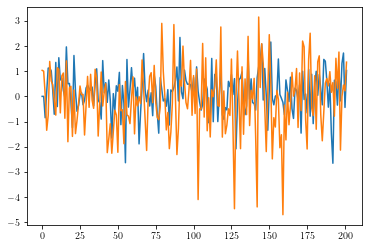

In [83]:
plt.plot(z)
plt.plot(z_true)

## Implementation of HMwG-SAEM to find the MAP

In [32]:
def hm_saem_gibbs(z0, theta0, y, nb_iter = 50, hm_iter=100, sigma_prop=1e-6, n_burn_in=10, alpha=3/2) :
    """SAEM implementation for a longitudinal model"""
    N, K = y.shape
    zk = np.copy(z0) 
    thetak = np.copy(theta0) 
    Sk = 0
    parameters = np.zeros((nb_iter, thetak.shape[0]))
    for k in range(1, nb_iter+1) :
        if k<= n_burn_in : 
            eps = 1
        else : 
            eps = (k-n_burn_in)**(-alpha)
        
        zk = metropolis_hasting_within_gibbs(zk, y, thetak, n_iter=5, hm_iter=hm_iter, sigma_prop=sigma_prop)
        Sk = Sk + eps*(S(y, zk) - Sk)
        
        thetak[0] = np.sqrt((K*N*Sk[0] + v**2)/(K*N+m+2))
        thetak[1] = np.sqrt((N*Sk[1] + v_xi**2)/(N+m_xi+2))
        thetak[2] = np.sqrt((N*Sk[2] + v_tau**2)/(N+m_tau+2))
        thetak[3] = (t0__/(s_t0**2) + Sk[3]/(sigma_t0**2))/(1/(s_t0**2) + 1/(sigma_t0**2))
        thetak[4] = (v0__/(s_v0**2) + Sk[4]/(sigma_v0**2))/(1/(s_v0**2) + 1/(sigma_v0**2))

        parameters[k-1] = thetak

    return thetak, zk, parameters

In [33]:
theta, _, _ = hm_saem_gibbs(z_true, theta_true, y, nb_iter = 1, hm_iter=100, sigma_prop=1e-1, n_burn_in=25, alpha=3/2)

In [34]:
theta

array([1.01369941, 1.1292245 , 1.5389883 , 1.01676587, 1.00093533])

In [122]:
z0 = np.zeros(2*N+2)
z0[0:2] = 1
theta, _, _ = hm_saem_gibbs(z0, np.ones(5), y, nb_iter = 3, hm_iter=100, sigma_prop=1e-1, n_burn_in=2, alpha=1)

In [123]:
theta

array([1.06226585, 1.11148976, 1.47119281, 1.        , 1.        ])

In [124]:
theta_true

array([0.99295067, 1.12461377, 1.44787238, 1.07208532, 1.        ])

The results are far from the true parameters. I've probably made some mistakes or chosen wrong hyperparameters.

#### Question 8

The Block Gibbs sampler will divide by $2$ the number of Metropolis-Hasting samples with respect to "one-at-time" Gibbs sampler for our model.

#### Question 9

Block HMwG

In [125]:
@jit(nopython=True)
def log_pi_z_i(z_i, param) :
    z_pop, z_ind, y, theta, i = np.copy(param[0]), np.copy(param[1]), np.copy(param[2]), np.copy(param[3]), param[4]
    N, K = y.shape
    t0 = z_pop[0]
    v0 = z_pop[1]
    xi = z_ind[:N]
    tau = z_ind[N:]
    xi[i] = z_i[0]
    tau[i] = z_i[1]
    d = lambda t : v0*(t - t0)
    t = np.zeros((N, K))
    for j in range(N) :
      t[j] = np.linspace(0, K, K)    
    t = (np.exp(xi)*((t - t0).T - tau)).T + t0
    t = d(t)

    log_prob = np.sum(-(y[i]-t[i,:])**2)/(2*theta[0]**2) - xi[i]**2/(2*theta[1]**2) - tau[i]**2/(2*theta[2]**2)

    return log_prob

@jit(nopython=True)
def log_pi_z_pop(z_pop, param) :
    z_ind, y, theta = param[0], param[1], param[2]
    N, K = y.shape
    t0 = z_pop[0]
    v0 = z_pop[1]
    xi = z_ind[:N]
    tau = z_ind[N:]
    d = lambda t : v0*(t - t0)
    t = np.zeros((N, k))
    for i in range(N) :
      t[i] = np.linspace(0, k, k)    
    t = (np.exp(xi)*((t - t0).T - tau)).T + t0
    t = d(t)

    log_prob = np.sum(-(y[i]-t)**2)/(2*theta[0]**2) - (t0 - theta[3])**2/(2*sigma_t0**2) - (v0 - theta[4])**2/(2*sigma_v0**2)

    return log_prob

In [147]:
def block_mhwg(z0, y, theta, n_iter=100, hm_iter=100, sigma_prop=1e-1) :
    z_pop = np.copy(z0[:2])
    z_ind = np.copy(z0[2:])
    N = int(len(z_ind)/2)
    for _ in range(n_iter) :
        perm = np.random.permutation(np.arange(N))
        xi = z_ind[:N]
        tau = z_ind[N:]
        for i in perm :
            z_i = np.array([xi[i], tau[i]]) #z_ind[2*i+2:2*i+4]
            z_i, _, _ = sym_metropolis_hasting(z_i, log_pi_z_i, param=(z_pop, z_ind, y, theta, i), sigma_prop=sigma_prop, n_iter=hm_iter)
            z_i = z_i[-1]
            z_ind[i] = z_i[0]
            z_ind[N+i] = z_i[1]
        z_pop, _, _ = sym_metropolis_hasting(z_pop, log_pi_z_pop, param=(z_ind, y, theta), sigma_prop=sigma_prop, n_iter=hm_iter)
        z_pop = z_pop[-1]
        log_prob.append(log_pi(np.concatenate((z_pop, z_ind)), param=theta))
    
    z = np.concatenate((z_pop, z_ind))
    return z

In [148]:
z0 = np.zeros(2*N+2)
z0[0:2] = 1
x = block_mhwg(z0, y, theta_true, n_iter=1, hm_iter=100, sigma_prop=1e-1)

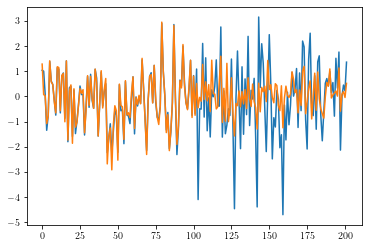

In [149]:
plt.plot(z_true)
plt.plot(x)

In [173]:
def hm_saem_block_gibbs(z0, theta0, y, nb_iter = 50, hm_iter=100, sigma_prop=1e-6, n_burn_in=10, alpha=3/2) :
    """SAEM implementation for a longitudinal model"""
    N, K = y.shape
    zk = np.copy(z0) 
    thetak = np.copy(theta0)
    Sk = 0
    parameters = np.zeros((nb_iter, thetak.shape[0]))
    for k in range(1, nb_iter+1) :
        if k<= n_burn_in : 
            eps = 1
        else : 
            eps = (k-n_burn_in)**(-alpha)
        
        zk = block_mhwg(zk, y, thetak, n_iter=10, hm_iter=hm_iter, sigma_prop=sigma_prop)
        Sk = Sk + eps*(S(y, zk) - Sk)
        
        thetak[0] = np.sqrt((K*N*Sk[0] + v**2)/(K*N+m+2))
        thetak[1] = np.sqrt((N*Sk[1] + v_xi**2)/(N+m_xi+2))
        thetak[2] = np.sqrt((N*Sk[2] + v_tau**2)/(N+m_tau+2))
        thetak[3] = (t0__/(s_t0**2) + Sk[3]/(sigma_t0**2))/(1/(s_t0**2) + 1/(sigma_t0**2))
        thetak[4] = (v0__/(s_v0**2) + Sk[4]/(sigma_v0**2))/(1/(s_v0**2) + 1/(sigma_v0**2))

        parameters[k-1] = thetak

    return thetak, zk, parameters

In [174]:
z0 = np.zeros(2*N+2)
z0[0:2] = 1
theta, _, parameters = hm_saem_block_gibbs(z0, np.ones(5), y, nb_iter = 5, hm_iter=100, sigma_prop=1e-1, n_burn_in=2, alpha=1)

In [175]:
theta

array([11.91619514,  5.70863234,  1.49633294,  1.83776769,  0.50011324])

In [176]:
theta_true

array([0.99295067, 1.12461377, 1.44787238, 1.07208532, 1.        ])

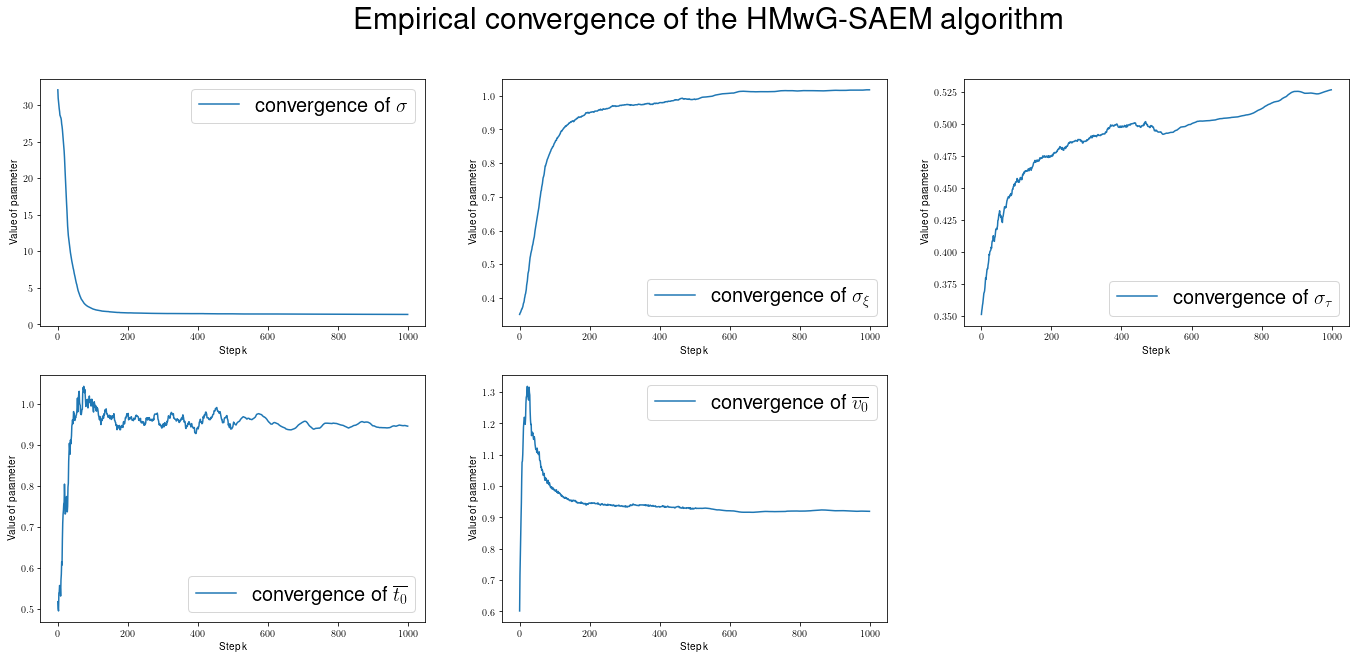

In [177]:
name_param = ["$\sigma$ ", r"$\sigma_{\xi}$", r"$\sigma_{\tau}$", r"$\overline{t_0}$", r"$\overline{v_0}$"]

fig = plt.figure(figsize=(40, 10))
t = 0.7
mid =  t*fig.subplotpars.left + (1-t)*fig.subplotpars.right
fig.suptitle("Empirical convergence of the HMwG-SAEM algorithm", fontsize=30, x=mid)

gs = GridSpec(2, 5, width_ratios=[2, 2, 2, 2, 2])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

for i in range(len(theta)) :
    q, r = i//3, i%3 
    axs[i].plot(param[:,i])
    axs[i].set_xlabel("Step k")
    axs[i].set_ylabel("Value of parameter")
    axs[i].legend(["convergence of " + name_param[i]], fontsize=20)
#plt.savefig('test.pdf') 
plt.show()

### 

## Exercise 2: Multiplicative Hasting-Metropolis

#### Question 1

We can write for all $u\in ]-1, 1[$

\begin{equation*}
    \mathbb{P}(Y = u x \mid X = x, \varepsilon = u) = \mathbb{P}\left(Y = \frac{x}{u}  \,\middle|\, X = x, \varepsilon = u \right) = \frac{1}{2} 
\end{equation*}


Then, the proposal kernel writes 

\begin{equation*}
\begin{aligned}
    Q(X, A) 
        & = \mathbb{E}[\mathbb{E}[\mathbb{1}_A(Y) \mid \varepsilon, X] \mid X ] \\
        & = \mathbb{E}\left[ \frac{1}{2}(\delta_{\varepsilon X}(A) + \delta_{\frac{X}{\varepsilon}}(A)) \,\middle|\, X \right] \\  
        & = \frac{1}{2}\int_{-1}^1{\left(\delta_{\varepsilon X}(A) + \delta_{\frac{X}{\varepsilon}}(A) \right) f(\varepsilon) d\varepsilon} \\
\end{aligned}
\end{equation*}

Given $X$, $Y$ takes its values in the set $$]-|X|, |X|[\cup ]-\infty, -|X|[\cup]|X|, +\infty[$$

Hence, with the changes of variables $y = \varepsilon X$ and $y = X/\varepsilon$ we can rewrite the kernel as 

\begin{equation*}
    Q(X, A) = \frac{1}{2}\int_{-|X|}^{|X|}{\delta_y(A)f\left(\frac{y}{X}\right)\frac{1}{|X|}dy} + \frac{1}{2}\int_{-\infty}^{-|X|}{\delta_y(A)f\left(\frac{X}{y}\right)\frac{|X|}{y^2}dy} + \frac{1}{2}\int_{|X|}^{+\infty}{\delta_y(A)f\left(\frac{X}{y}\right)\frac{|X|}{y^2}dy}
\end{equation*}

Hence 

\begin{equation*}
    Q(x, dy) = 1_{\{|y|\leqslant |x|\}}\frac{1}{2|x|}f\left(\frac{y}{x}\right)dy + 1_{\{|y|\geqslant |x|\}}f\left(\frac{x}{y}\right)\frac{|x|}{2y^2}dy 
\end{equation*}

#### Question 2

The acceptation ratio writes 

\begin{equation*}
    \alpha(x, y) = \frac{Q(x, y)\pi(y)}{Q(y, x)\pi(x)} = 1_{\{|y|\leqslant |x|\}}\frac{|y|\pi(y)}{|x|\pi(x)} + 1_{\{|y|\geqslant |x|\}} \frac{|y|}{|x|}\frac{\pi(y)}{\pi(x)} 
                = \frac{|y|}{|x|}\frac{\pi(y)}{\pi(x)} 
\end{equation*}

#### Question 3-4

In [145]:
def multiplicative_metropolis_hasting(x0, log_pi, support_pi, n_iter=100) :
    sample = np.zeros(n_iter)
    x = x0
    for k in range(n_iter) :
        eps = np.random.uniform(-1, 1)
        u = np.random.uniform(0, 1)
        if u<=0.5  : 
            y = eps*x
        else : 
            y = x/eps

        a =  np.exp(min(0, np.log(abs(y)) - np.log(abs(x)) + log_pi(y) - log_pi(x))) * support_pi(y) 
        #a = np.exp(min(0, a)) * support_pi(y)
        u = np.random.uniform(0, 1)
        if u<=a : 
            x = y  
        sample[k] = x
    return sample

In [146]:
# Uniform distribution over [2, 3]
log_pi = lambda x : 1
support_pi = lambda y : (2<y)*(y<3)

N = 100_000
x = multiplicative_metropolis_hasting(x0=2.5, log_pi=log_pi, support_pi=support_pi, n_iter=N)

t = np.linspace(2, 3)
pdf = np.ones(len(t))

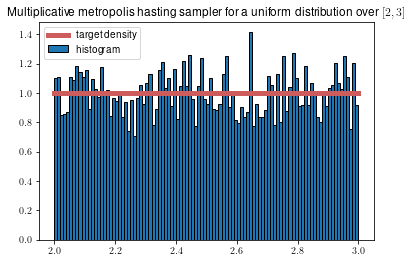

In [147]:
fig = plt.figure(figsize=(6, 4))
plt.hist(x[200:], bins=100, edgecolor="k", density=True)
plt.plot(t, pdf, c="indianred", lw=5)
plt.legend(["target density", "histogram"])
plt.title("Multiplicative metropolis hasting sampler for a uniform distribution over $[2, 3]$")
plt.show()

In [148]:
# Translated exponential distribution

log_pi = lambda x : -5*(x-1)
support_pi = lambda y : (y>1)

N = 100_000
x = multiplicative_metropolis_hasting(x0=1/5, log_pi=log_pi, support_pi=support_pi, n_iter=N)

t = np.linspace(1, 3)
pdf = 5*np.exp(-5*(t-1))

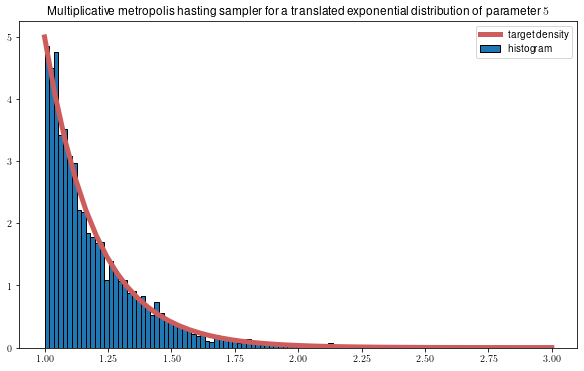

In [149]:

fig = plt.figure(figsize=(10, 6))
plt.hist(x[N//2:], bins=100, edgecolor="k", density=True)
plt.plot(t, pdf, c="indianred", lw=5)
plt.legend(["target density", "histogram"])
plt.title("Multiplicative metropolis hasting sampler for a translated exponential distribution of parameter $5$")

plt.show()

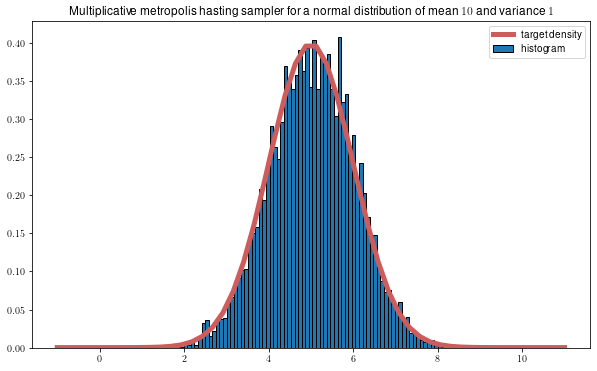

In [150]:
# Standard normal distribution

m = 5
log_pi = lambda x : -(x-m)**2/2
support_pi = lambda y : 1

N = 100_000
x = multiplicative_metropolis_hasting(x0=m+1e-1, log_pi=log_pi, support_pi=support_pi, n_iter=N)


t = np.linspace(m-6, m+6)
pdf = np.exp(-(t-m)**2 /2)/np.sqrt(2*np.pi)
fig = plt.figure(figsize=(10, 6))
plt.hist(x[N//2:], bins=100, edgecolor="k", density=True)
plt.plot(t, pdf, c="indianred", lw=5)
plt.legend(["target density", "histogram"])
plt.title("Multiplicative metropolis hasting sampler for a normal distribution of mean $10$ and variance $1$")

plt.show()